## Word count analysis over time

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import CHAPTERS_DATA_TSV

In [3]:
def count_words(s: str):
    return len(s.split())

In [4]:
def words_per_second(row: pd.Series) -> float | None:
    n_words = row["word_count"]
    duration_s = row["duration_sec"]

    if pd.notna(duration_s) or pd.notna(n_words):
        return n_words / duration_s
    else:
        return None


def get_duration_sec(row: pd.Series) -> float | None:
    start_ms = row["start"]
    end_ms = row["end"]

    if pd.notna(start_ms) or pd.notna(end_ms):
        duration_sec = (float(end_ms) - float(start_ms)) / 1000
        return duration_sec
    else:
        return None

In [5]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]
len(df)

2369

In [6]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

In [7]:
df_description = "flagged as combat scenes"
df = DF_COMBAT

print(f"Data size: {len(df)}")

df["word_count"] = df["audio_transcription"].apply(count_words)
df["duration_sec"] = df.apply(lambda row: get_duration_sec(row), axis=1)
df["word_count_per_second"] = df.apply(lambda row: words_per_second(row), axis=1)

Data size: 751


In [8]:
df["word_count_per_minute"] = df["word_count_per_second"]*60
df["word_count_per_minute"].describe()

count    751.000000
mean      50.787673
std       24.331483
min        7.304348
25%       35.751347
50%       45.494505
75%       60.000000
max      205.714286
Name: word_count_per_minute, dtype: float64

In [9]:
df =df.sort_values("word_count_per_minute", ascending=False)
df[["audio_transcription", "word_count_per_minute"]]

,audio_transcription,word_count_per_minute
927,Nach der Einnahme von Nikolajew stießen Verbän...,205.714286
1313,Der Sultan von Marokko traf zu einem Besuch de...,166.666667
1417,Der Reichsaußenminister des Auswärtigen von Ri...,160.000000
789,Die Sowjets haben auf dem Rückzug große Streck...,159.230769
2325,Der letzte Widerstand der Aufständischen in Wa...,156.000000
...,...,...
288,Storzkampf-Flugzeuge von Typ Ju 87 rollen an d...,13.663366
782,Schritt um Schritt kämpfen sich unsere Truppen...,13.109244
618,Die griechische Front. Artillerie und Stukas z...,12.151899
1090,Die Krim greifen an und brechen in schweren Ei...,11.123596


In [10]:
x = df['episode']
y = df['word_count_per_minute']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)
mean = df["word_count_per_minute"].mean()
median = df["word_count_per_minute"].median()
std = df["word_count_per_minute"].std()
print(f"Median: {median:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Standard deviation: {std:.2f}")
print(f"Pearson:\tr = {pearson_r}\tp={pearson_p}")
print(f"Spearman:\tr = {spearman_r}\tp={spearman_p}")


Median: 45.49
Mean: 50.79
Standard deviation: 24.33
Pearson:	r = 0.21758035189708008	p=1.6905835647388575e-09
Spearman:	r = 0.2408178042589348	p=2.2759690447274412e-11


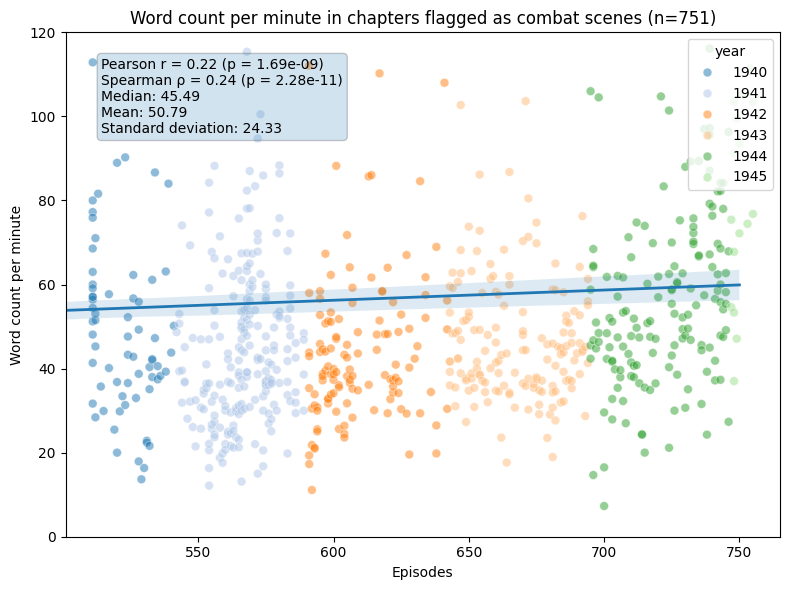

In [11]:
df_sorted = df.sort_values(["episode", "chapter"]).reset_index(drop=True)

text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})\n"
    f"Median: {median:.2f}\n"
    f"Mean: {mean:.2f}\n"
    f"Standard deviation: {std:.2f}"
)

plt.figure(figsize=(8, 6))

ax = sns.scatterplot(  
    data=df_sorted,
    x="episode",
    y="word_count_per_minute",
    hue="year",
    alpha=0.5,
    palette="tab20",
    legend="auto",
    s=40,
)

ax = sns.regplot(
    x=df_sorted.index,
    y=df_sorted["word_count_per_minute"],
    scatter=False,
    line_kws={"linewidth": 2},
)

plt.text(
    0.05,
    0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", alpha=0.2),
)

plt.xlim(min(df["episode"]) - 10, max(df["episode"]) + 10)
plt.ylim(0, 120)
plt.xlabel("Episodes")
plt.ylabel("Word count per minute")
plt.title(f"Word count per minute in chapters {df_description} (n={len(df_sorted)})")
sns.move_legend(ax, "upper right",bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [17]:
episode_stats = df.groupby(['episode', 'year'])['word_count_per_minute'].agg(
    mean_word_count_per_minute='mean',
    median_word_count_per_minute='median',
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75)
).reset_index()

In [16]:
episode_stats

,episode,year,mean_shot_len,median_shot_len,q25,q75
0,511,1940,62.127521,58.123667,53.618832,70.402930
1,512,1940,49.851318,51.502146,45.275229,53.043478
2,513,1940,81.600000,81.600000,81.600000,81.600000
3,514,1940,35.736677,35.736677,35.736677,35.736677
4,515,1940,29.912023,29.912023,29.912023,29.912023
...,...,...,...,...,...,...
212,750,1945,82.886957,82.886957,77.530435,88.243478
213,751,1945,105.000000,105.000000,105.000000,105.000000
214,753,1945,98.805225,98.805225,86.628890,110.981560
215,754,1945,134.578755,140.000000,125.714286,146.153846


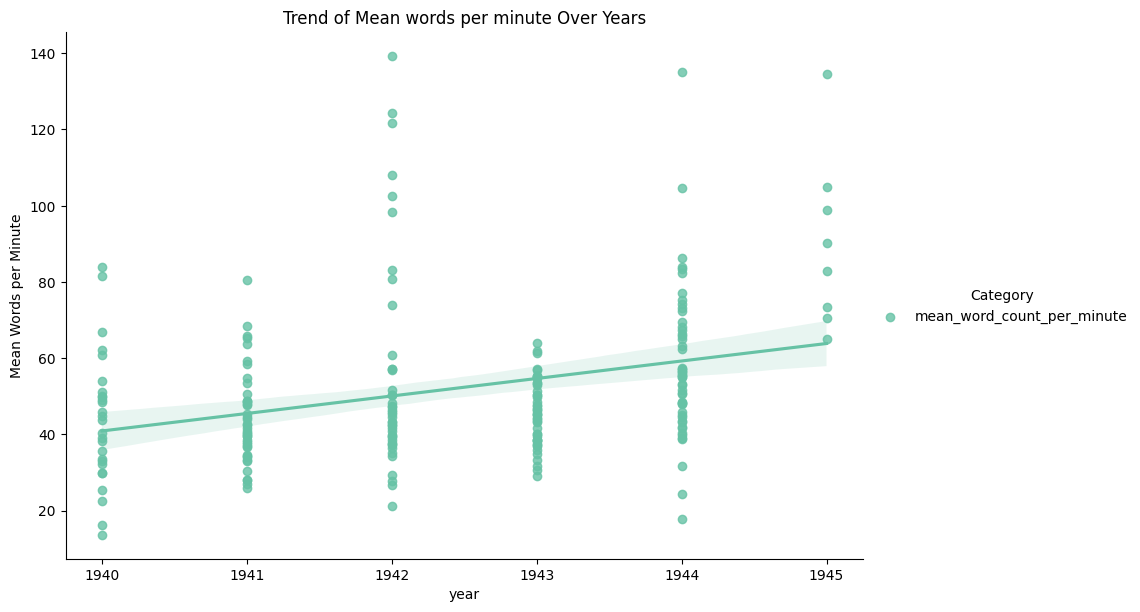

In [24]:
episode_stats_long = episode_stats.melt(
    id_vars=['year', 'episode'],
    value_vars=['mean_word_count_per_minute'],
    var_name='Category',
    value_name='Mean Words per Minute'
)

# Plot trendlines using linear regression
sns.lmplot(
    data=episode_stats_long,
    x='year',
    y='Mean Words per Minute',
    hue='Category',
    palette='Set2',
    height=6,
    aspect=1.5,
    ci=95  # 95% confidence interval
)
plt.title("Trend of Mean words per minute Over Years")
plt.show()